In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import sys
print (sys.version)

2.7.15 |Anaconda, Inc.| (default, Nov 13 2018, 17:07:45) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [226]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import importlib
import pandas as pd
from scipy.stats import bernoulli
from matplotlib import cm
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot
import random
import pickle

import generative_lib

In [227]:
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [228]:
reload(generative_lib)

<module 'generative_lib' from 'generative_lib.pyc'>

In [229]:
from classifiers import AdversarialExample

In [230]:
def load_pkl(adversary_path, delta = 500.0):
    af = open(adversary_path, "rb")
    exs = pickle.load(af)
    af.close()

    # remove all adversary that is None
    exs = filter(lambda ex: ex is not None, exs)
    # remove all adversary whose norm is > delta
    exs = filter(lambda ex: ex.adv_diff_norm < delta, exs)
    # sort examples by increasing diff norm
    exs.sort(key = lambda ex: ex.adv_diff_norm)
    
    return exs

In [231]:
def prod_lat(exs,AE,AEgen):
    
    # reconstruction by projection
    maxit = 500
    gamma  = 0.5
    x0    = torch.zeros([num_hidden_1])
    rand_init = 1
    sigma = 5
    
    AE_latent_L2  = [];
    AE_latent     = [];
    
    for ex in exs:
        Gstar = ex.adv_x.reshape(image_width*image_width)

        # latent via encoder
        latEnc = AE.encoder(Gstar)
        AE_latent.append(latEnc)

        # latent via projection
        Gstar = ex.adv_x.reshape(image_width*image_width)
        [_,latL2] = generative_lib.Full_Projection(AEgen, Gstar, maxit, gamma, rand_init, sigma, x0, generative_lib.L2_Project)
        AE_latent_L2.append(latL2)
   
    return [AE_latent,AE_latent_L2]

In [232]:
def VAE_prod_lat(exs,VAE,VAEgen):
    
    # reconstruction by projection
    maxit = 500
    gamma  = 0.5
    x0    = torch.zeros([num_latent])
    rand_init = 1
    sigma = 5
    
    VAE_latent_L2  = [];
    VAE_latent     = [];
    
    for ex in exs:
        Gstar = ex.x.reshape([1,image_width*image_width])
        
        # latent via encoder
        [latEnc,z_mean,z_log_var] = VAE.encoder(Gstar)
        VAE_latent.append(latEnc)
    
        # latent via projection
        Gstar = ex.x.reshape(image_width*image_width) #model.decoder(test_enc).detach()
        [_,latL2] = generative_lib.Full_Projection(VAEgen, Gstar, maxit, gamma, rand_init, sigma, x0, generative_lib.L2_Project)
        VAE_latent_L2.append(latL2)
   
    return [VAE_latent,VAE_latent_L2]

In [233]:
image_width = 28

# AutoEncoder

In [236]:
pathAE = 'trained_models/AE_MNIST.pt'
num_features = 784
num_hidden_1 = 32

AE = generative_lib.AE_1L(num_features,num_hidden_1)
AE.load_state_dict(torch.load(pathAE))
AE.eval()

AEgen = generative_lib.AEcopyGen(AE,num_features,num_hidden_1)

## LRL

In [ ]:
adversary_path = 'adversary_dataset/CONFIDENCE_50/mnist_img_50conf_advex/Logistic_LRL_advex/'
pkl_path       = adversary_path + 'advex.pkl'
exs = load_pkl(pkl_path)
[AE_latent,AE_latent_L2] = prod_lat(exs,AE,AEgen)

In [246]:
# save latents via Encoder
pickle_f = open(adversary_path+'AE_latent.pkl', "w+")
pickle.dump(AE_latent, pickle_f)
pickle_f.close()
    
# save latents via Projection
pickle_f = open(adversary_path+'AE_latent_L2.pkl', "w+")
pickle.dump(AE_latent_L2, pickle_f)
pickle_f.close()

## Logistic_1L

In [272]:
adversary_path = 'adversary_dataset/CONFIDENCE_50/mnist_img_50conf_advex/Logistic_1L_advex/'
pkl_path       = adversary_path + 'advex.pkl'
exs = load_pkl(pkl_path)
[AE_latent,AE_latent_L2] = prod_lat(exs,AE,AEgen)

In [273]:
# save latents via Encoder
pickle_f = open(adversary_path+'AE_latent.pkl', "w+")
pickle.dump(AE_latent, pickle_f)
pickle_f.close()
    
# save latents via Projection
pickle_f = open(adversary_path+'AE_latent_L2.pkl', "w+")
pickle.dump(AE_latent_L2, pickle_f)
pickle_f.close()

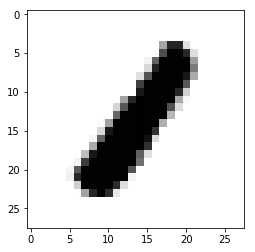

In [320]:
# Random img in the test set
idx = 1 #random.randint(0, len(exs))
test_img = exs[idx].x
plt.imshow(test_img.detach().numpy().reshape([image_width,image_width]),cmap='binary')

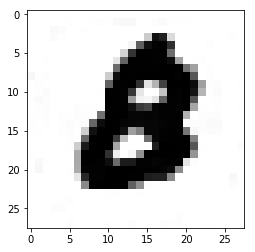

In [318]:
# Random img in the test set
#idx = 0#random.randint(0, len(exs))
test_img = exs[idx].adv_x
plt.imshow(test_img.detach().numpy().reshape([image_width,image_width]),cmap='binary')

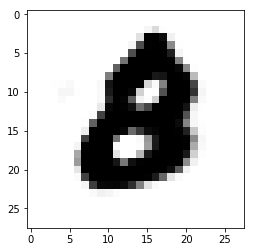

In [319]:
lat = AE_latent_L2[idx]
clean_img = AEgen(lat)
plt.imshow(clean_img.detach().numpy().reshape([image_width,image_width]),cmap='binary')

## Logistic_2L

In [292]:
adversary_path = 'adversary_dataset/CONFIDENCE_50/mnist_img_50conf_advex/Logistic_2L_advex/'
pkl_path       = adversary_path + 'advex.pkl'
exs = load_pkl(pkl_path)
[AE_latent,AE_latent_L2] = prod_lat(exs,AE,AEgen)

In [293]:
# save latents via Encoder
pickle_f = open(adversary_path+'AE_latent.pkl', "w+")
pickle.dump(AE_latent, pickle_f)
pickle_f.close()
    
# save latents via Projection
pickle_f = open(adversary_path+'AE_latent_L2.pkl', "w+")
pickle.dump(AE_latent_L2, pickle_f)
pickle_f.close()

In [322]:
adversary_path = 'adversary_dataset/CONFIDENCE_50/mnist_img_50conf_advex/Logistic_2L_advex/'
pkl_path       = adversary_path + 'advex.pkl'
exs = load_pkl(pkl_path)

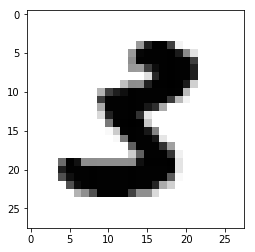

In [324]:
idx = 0
ex = exs[idx]
test_img = ex.x
plt.imshow(test_img.detach().numpy().reshape([image_width,image_width]),cmap='binary')

# Variational AE 

In [213]:
pathVAE = 'trained_models/VAE_MNIST.pt'

num_features = 784
num_hidden_1 = 150
num_latent   = 32

VAE = generative_lib.VAE(num_features,num_hidden_1,num_latent)
VAE.load_state_dict(torch.load(pathVAE))
VAE.eval()

VAEgen = generative_lib.VAEcopyGen(VAE,num_features,num_hidden_1,num_latent)

## LRL

In [218]:
adversary_path = 'adversary_dataset/CONFIDENCE_50/mnist_img_advex/Logistic_LRL_advex/'
pkl_path       = adversary_path + 'advex.pkl'
exs = load_pkl(pkl_path)
[VAE_latent,VAE_latent_L2] = VAE_prod_lat(exs,VAE,VAEgen)

In [219]:
# save latents via Encoder
pickle_f = open(adversary_path+'VAE_latent.pkl', "w+")
pickle.dump(VAE_latent, pickle_f)
pickle_f.close()
    
# save latents via Projection
pickle_f = open(adversary_path+'VAE_latent_L2.pkl', "w+")
pickle.dump(VAE_latent_L2, pickle_f)
pickle_f.close()

## Logistic_1L

In [221]:
adversary_path = 'adversary_dataset/CONFIDENCE_50/mnist_img_advex/Logistic_1L_advex/'
pkl_path       = adversary_path + 'advex.pkl'
exs = load_pkl(pkl_path)
[VAE_latent,VAE_latent_L2] = VAE_prod_lat(exs,VAE,VAEgen)

In [222]:
# save latents via Encoder
pickle_f = open(adversary_path+'VAE_latent.pkl', "w+")
pickle.dump(VAE_latent, pickle_f)
pickle_f.close()
    
# save latents via Projection
pickle_f = open(adversary_path+'VAE_latent_L2.pkl', "w+")
pickle.dump(VAE_latent_L2, pickle_f)
pickle_f.close()

## Logistic_2L

In [223]:
adversary_path = 'adversary_dataset/CONFIDENCE_50/mnist_img_advex/Logistic_2L_advex/'
pkl_path       = adversary_path + 'advex.pkl'
exs = load_pkl(pkl_path)
[VAE_latent,VAE_latent_L2] = VAE_prod_lat(exs,VAE,VAEgen)

In [224]:
# save latents via Encoder
pickle_f = open(adversary_path+'VAE_latent.pkl', "w+")
pickle.dump(VAE_latent, pickle_f)
pickle_f.close()
    
# save latents via Projection
pickle_f = open(adversary_path+'VAE_latent_L2.pkl', "w+")
pickle.dump(VAE_latent_L2, pickle_f)
pickle_f.close()